In [3]:
from split_data import split
import numpy as np
import torch
from torchvision.datasets import ImageFolder
import torch.nn as nn
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from utils import *


In [4]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f"Using {device}")

Using mps


In [5]:
source_path = "../Data/Augmentation/Tomato"
training_path = "../train_data/Tomato"
testing_path = "../test_data/Tomato"
train_test_ratio = 0.7
split(source_path, training_path, testing_path, train_test_ratio) 

Finish splitting No_leaves
[Training Samples:800, Testing Samples:343]   Original Samples:1143
---------------------
Finish splitting Late_blight
[Training Samples:1336, Testing Samples:573]   Original Samples:1909
---------------------
Finish splitting Septoria_leaf_spot
[Training Samples:1240, Testing Samples:531]   Original Samples:1771
---------------------
Finish splitting Tomato_Yellow_Leaf_Curl_Virus
[Training Samples:3750, Testing Samples:1607]   Original Samples:5357
---------------------
Finish splitting Healthy
[Training Samples:1114, Testing Samples:477]   Original Samples:1591
---------------------
Finish splitting Early_blight
[Training Samples:700, Testing Samples:300]   Original Samples:1000
---------------------
Finish splitting Target_Spot
[Training Samples:983, Testing Samples:421]   Original Samples:1404
---------------------
Finish splitting Leaf_Mold
[Training Samples:700, Testing Samples:300]   Original Samples:1000
---------------------
Finish splitting Tomato_m

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


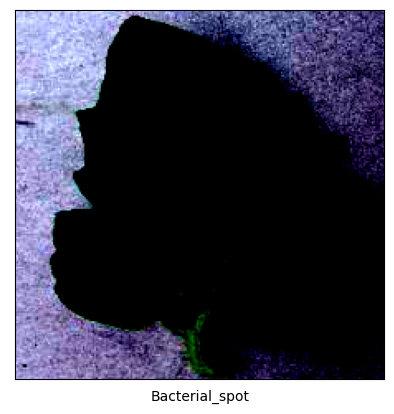

In [6]:
# -------------[transform into suitable size for transfer learning]--------------------
transformation = preprocess()

train_dataset = ImageFolder(training_path, transform = transformation)

test_dataset = ImageFolder(testing_path,transform = transformation)

classes = train_dataset.classes

#display the first image in the dataset
display_img(*train_dataset[0], classes)

In [10]:
batch_size = 32
train_val_ratio = 0.8
val_size = int(np.round(len(train_dataset) * (1-train_val_ratio)))
train_size = len(train_dataset) - val_size 

train_data, val_data = random_split(train_dataset,[train_size,val_size])
print(f"Length of Train Data : {len(train_data)}")
print(f"Length of Validation Data : {len(val_data)}")

train_dl = DataLoader(train_data, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
val_dl = DataLoader(val_data, batch_size, num_workers = 4, pin_memory = True)

test_dl = DataLoader(test_dataset, batch_size, num_workers = 4, pin_memory = True)

Length of Train Data : 11188
Length of Validation Data : 2797


### EfficientB0 Model

In [42]:
efficient_model = load_efficient_net().to(device)

num_classes = len(classes)

efficient_model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=num_classes, bias=True)
).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(efficient_model.parameters(), lr=0.001)

# efficientNet B0 model
efficient_results = train(model=efficient_model,
                train_dataloader=train_dl,
                val_dataloader=val_dl,
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=15,
                device=device)

torch.save(efficient_model, "../Models/tomato_efficient_model.pt")

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7506 | train_acc: 0.8052 | train_f1: 0.8052 | val_loss: 0.3654 | val_acc: 0.9111 | val_f1: 0.9110 | 
--------------------------------------------------------------
Epoch: 2 | train_loss: 0.3523 | train_acc: 0.9034 | train_f1: 0.9035 | val_loss: 0.2742 | val_acc: 0.9313 | val_f1: 0.9314 | 
--------------------------------------------------------------
Epoch: 3 | train_loss: 0.2839 | train_acc: 0.9173 | train_f1: 0.9173 | val_loss: 0.2295 | val_acc: 0.9412 | val_f1: 0.9414 | 
--------------------------------------------------------------
Epoch: 4 | train_loss: 0.2572 | train_acc: 0.9249 | train_f1: 0.9248 | val_loss: 0.1990 | val_acc: 0.9455 | val_f1: 0.9457 | 
--------------------------------------------------------------
Epoch: 5 | train_loss: 0.2267 | train_acc: 0.9278 | train_f1: 0.9279 | val_loss: 0.2042 | val_acc: 0.9437 | val_f1: 0.9439 | 
--------------------------------------------------------------
Epoch: 6 | train_loss: 0.2073 | train_acc: 0.9359 | tra

In [15]:
# accuracy for efficientNet b0
if torch.backends.mps.is_available():
    efficient_model = torch.load("../Models/tomato_efficient_model.pt", map_location=torch.device('mps'))
elif torch.cuda.is_available():
    efficient_model = torch.load("../Models/tomato_efficient_model.pt", map_location=torch.device('cuda'))
    
efficient_report = test_run(efficient_model, test_dl, device, batch_size, classes)
print(efficient_report)

                                      precision    recall  f1-score   support

                      Bacterial_spot       0.98      0.97      0.97       638
                        Early_blight       0.94      0.89      0.91       300
                             Healthy       0.95      0.99      0.97       477
                         Late_blight       0.98      0.96      0.97       573
                           Leaf_Mold       0.96      0.97      0.96       300
                           No_leaves       0.99      1.00      1.00       343
                  Septoria_leaf_spot       0.96      0.95      0.96       531
Spider_mites Two-spotted_spider_mite       0.94      0.99      0.96       503
                         Target_Spot       0.95      0.92      0.94       421
       Tomato_Yellow_Leaf_Curl_Virus       0.98      0.99      0.99      1607
                 Tomato_mosaic_virus       0.99      0.95      0.97       300

                            accuracy                          

### MobileNetV2 Model

In [44]:
mobile_model = load_mobile_net().to(device)

mobile_model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=False),
    nn.Linear(in_features=1280, out_features=num_classes, bias=True)
).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mobile_model.parameters(), lr=0.001)

# MobileNet V2 model
mobile_results = train(model=mobile_model,
                train_dataloader=train_dl,
                val_dataloader=val_dl,
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=15,
                device=device)

torch.save(mobile_model, "../Models/tomato_mobile_model.pt")

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.8230 | train_acc: 0.7921 | train_f1: 0.7922 | val_loss: 0.4149 | val_acc: 0.9036 | val_f1: 0.9035 | 
--------------------------------------------------------------
Epoch: 2 | train_loss: 0.3670 | train_acc: 0.9051 | train_f1: 0.9050 | val_loss: 0.2919 | val_acc: 0.9233 | val_f1: 0.9228 | 
--------------------------------------------------------------
Epoch: 3 | train_loss: 0.2938 | train_acc: 0.9196 | train_f1: 0.9196 | val_loss: 0.2463 | val_acc: 0.9336 | val_f1: 0.9331 | 
--------------------------------------------------------------
Epoch: 4 | train_loss: 0.2461 | train_acc: 0.9309 | train_f1: 0.9309 | val_loss: 0.2230 | val_acc: 0.9361 | val_f1: 0.9356 | 
--------------------------------------------------------------
Epoch: 5 | train_loss: 0.2137 | train_acc: 0.9405 | train_f1: 0.9406 | val_loss: 0.2015 | val_acc: 0.9400 | val_f1: 0.9396 | 
--------------------------------------------------------------
Epoch: 6 | train_loss: 0.2039 | train_acc: 0.9418 | tra

In [16]:
# MobileNet V2 accuracy

if torch.backends.mps.is_available():
    mobile_model = torch.load("../Models/tomato_mobile_model.pt", map_location=torch.device('mps'))
elif torch.cuda.is_available():
    mobile_model = torch.load("../Models/tomato_mobile_model.pt", map_location=torch.device('cuda'))

mobile_report = test_run(mobile_model, test_dl, device, batch_size, classes)
print(mobile_report)

                                      precision    recall  f1-score   support

                      Bacterial_spot       0.97      0.97      0.97       638
                        Early_blight       0.92      0.89      0.90       300
                             Healthy       0.98      0.99      0.98       477
                         Late_blight       0.98      0.95      0.96       573
                           Leaf_Mold       0.97      0.97      0.97       300
                           No_leaves       1.00      1.00      1.00       343
                  Septoria_leaf_spot       0.97      0.97      0.97       531
Spider_mites Two-spotted_spider_mite       0.90      0.98      0.94       503
                         Target_Spot       0.96      0.91      0.93       421
       Tomato_Yellow_Leaf_Curl_Virus       0.99      0.99      0.99      1607
                 Tomato_mosaic_virus       0.99      0.96      0.97       300

                            accuracy                          

### Predicting Single Image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


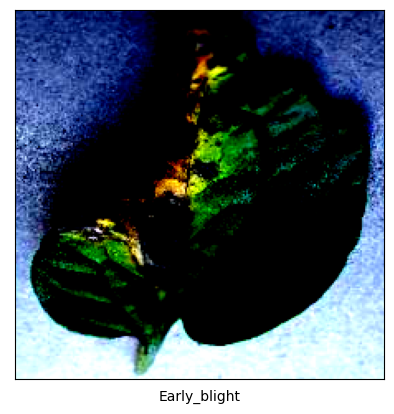

In [13]:
from PIL import Image
test_img_path = "/Users/afflatus/Documents/UoM_MSc/Diss/Data/Augmentation/Tomato/Early_blight/image (46).JPG"

img = Image.open(test_img_path)


img1 = transformation(img)

display_img(img1, predict(mobile_model, test_img_path, device), classes)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


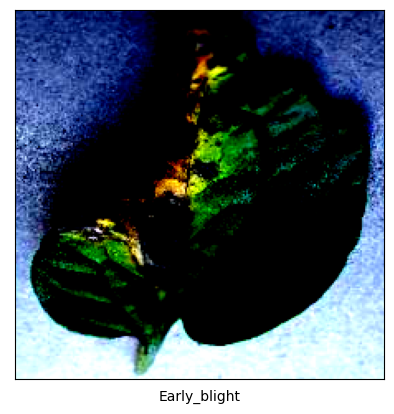

In [14]:
display_img(img1, predict(efficient_model, test_img_path, device), classes)